In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

 # linear algebra
# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
print(os.listdir("../input/cell_images/cell_images"))

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

['Parasitized', 'Uninfected']


In [3]:
train_trans = transforms.Compose([transforms.Resize((64, 64)),
#                                  transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
test_trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [4]:
data_dir = "../input/cell_images/cell_images"
dataset = datasets.ImageFolder(data_dir, transform=train_trans)

In [5]:
test_size = 0.2
batch_size = 64
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.float(num_train) * test_size)

train_set, test_set = indices[split-1:], indices[:split-1]
train_loader = DataLoader(dataset, sampler=SubsetRandomSampler(train_set), batch_size=batch_size)
test_loader = DataLoader(dataset, sampler=SubsetRandomSampler(test_set), batch_size=batch_size//2)
print(len(train_set), len(test_set))

22048 5510


In [6]:
classes=['parasitized', 'uninfected']

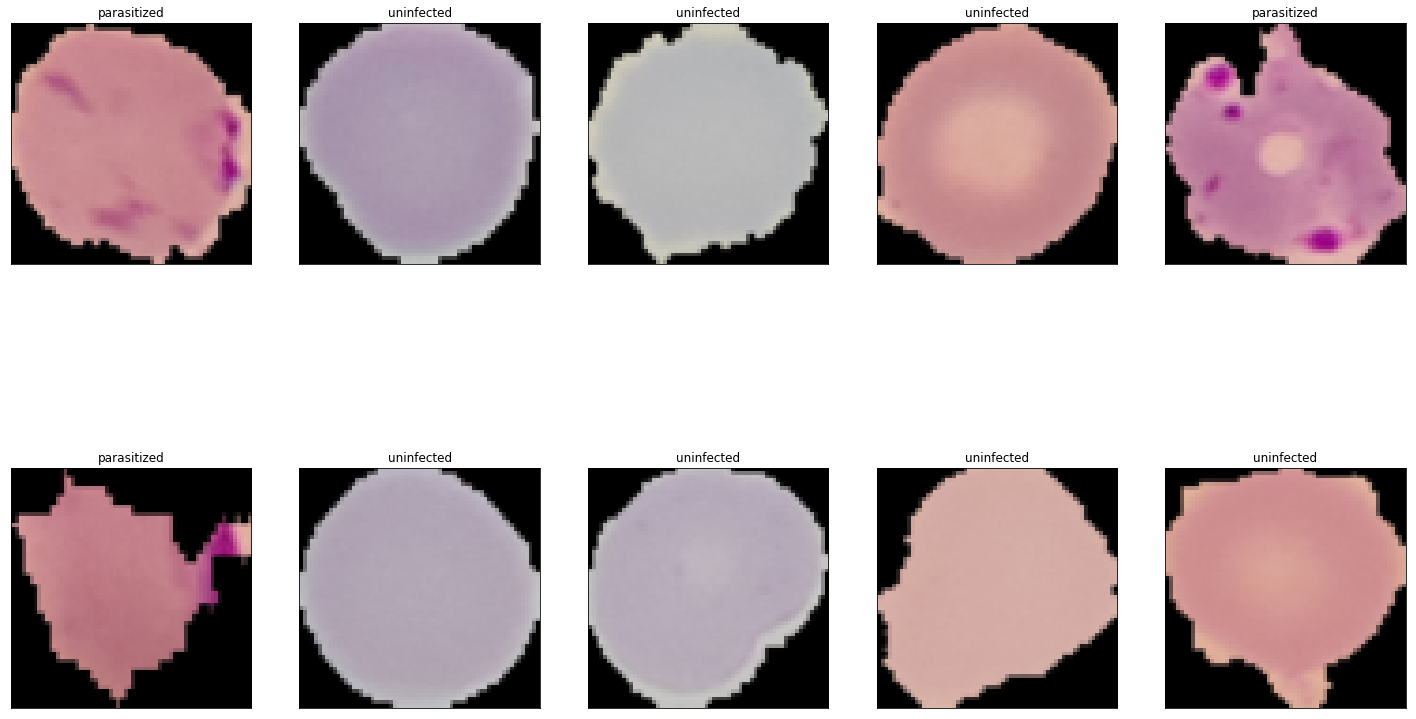

In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Preprocessing

In [9]:
def turn_int_bw(img):
    rows,cols = img.shape
    for i in range(rows):
        for j in range(cols):
            if img[i, j] == [136,7,113]:
                img[i, j] = [255, 255, 255]
            else:
                img[i, j] = [0, 0, 0]
    return img

In [10]:
class MalNet(nn.Module):
    def __init__(self):
        super(MalNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
        out = self.layer4(out)
#         print(out.shape)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
#         print(out.shape)
        out = self.fc1(out)
#         print(out.shape)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
#         print(out.shape)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
#         print(out.shape)
        return out

In [11]:
model = MalNet()
model.to(device)
error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MalNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNor

In [12]:
def validation():
    correct = 0
    total = 0
    class_total = [0 for _ in range(2)]
    class_correct = [0 for _ in range(2)]
    batch_size = 64//2

#     predict = []

    model.eval()    # explicitly stating the testing 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to (device)

#             actual.append(labels.data.tolist())
            test = images.view(-1, 3, 64, 64)
            outputs = model(test)
            predicted = torch.max(outputs, 1)[1]
#             predict.append(predicted.data.tolist())
            total += len(labels)
            correct += (predicted == labels).sum().item()
            # Calculating classwise accuracy
            c = (predicted == labels).squeeze()
#         for i in range(batch_size):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
    acc = correct * 100 / total
    print("Accuracy on the Test set: {:.2f}%".format(acc))
    model.train()
#     print(type(acc))
    return acc
# for i in range(2):
#     print("Accuracy of {} :  {:.2f}%   [{} / {}]".format(classes[i], class_correct[i] * 100 / class_total[i], 
#                                            class_correct[i], class_total[i]))

In [13]:
num_epochs = 20
batch_size = 64
check_every = 100
step = 0
acc = 0
best_model = model
for epoch in range(num_epochs):
    train_loss = 0.
    model.train()    # explictily stating the training
    
    for i, (images, labels) in enumerate(train_loader):
        step += 1
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 64, 64)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    #back-propagation
        optimizer.step()
        
        train_loss += loss.item() * batch_size
        if step % check_every == 0:
            if acc < validation():
                best_model = model

     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

Accuracy on the Test set: 93.12%
Accuracy on the Test set: 95.90%
Accuracy on the Test set: 95.17%
Epoch: 1, Loss: 0.2021
Accuracy on the Test set: 96.41%
Accuracy on the Test set: 96.33%
Accuracy on the Test set: 96.44%
Epoch: 2, Loss: 0.1109
Accuracy on the Test set: 96.42%
Accuracy on the Test set: 96.48%
Accuracy on the Test set: 96.33%
Accuracy on the Test set: 96.70%
Epoch: 3, Loss: 0.1032
Accuracy on the Test set: 96.10%
Accuracy on the Test set: 96.59%
Accuracy on the Test set: 96.59%
Epoch: 4, Loss: 0.0993
Accuracy on the Test set: 96.75%
Accuracy on the Test set: 96.41%
Accuracy on the Test set: 96.15%
Accuracy on the Test set: 96.33%
Epoch: 5, Loss: 0.0961
Accuracy on the Test set: 96.55%
Accuracy on the Test set: 96.68%
Accuracy on the Test set: 96.52%
Epoch: 6, Loss: 0.0915
Accuracy on the Test set: 96.30%
Accuracy on the Test set: 96.64%
Accuracy on the Test set: 96.77%
Accuracy on the Test set: 96.59%
Epoch: 7, Loss: 0.0872
Accuracy on the Test set: 96.66%
Accuracy on th

In [14]:
correct = 0
total = 0
class_total = [0 for _ in range(2)]
class_correct = [0 for _ in range(2)]
batch_size = 64//2

# predict = []

best_model.eval()    # explicitly stating the testing 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)

#         actual.append(labels.data.tolist())
        test = images.view(-1, 3, 64, 64)
        outputs = best_model(test)
        predicted = torch.max(outputs, 1)[1]
#         predict.append(predicted.data.tolist())
        total += len(labels)
        correct += (predicted == labels).sum().item()
            # Calculating classwise accuracy
        c = (predicted == labels).squeeze()
#         for i in range(batch_size):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
acc = correct * 100 / total
print("Accuracy on the Test set: {:.2f}%".format(acc))

Accuracy on the Test set: 96.46%
